# Introduction

The Dynamic Mode Decomposition (DMD) aims to find the eigenvectors of the operator $A$ that linearly approximate a dinamyc system:

\begin{equation}
x_{k+1} = A x_{k}
\end{equation}




In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri
from matplotlib.animation import FuncAnimation 

path = '/Users/alberto/Documents/Teaching/ERCOFTAC/DMD_Peppe' # Path to the dataset 
timesteps = np.arange(0., 0.25, step=0.00025) # Number of timesteps 

# We load the first timestep to get the spatial coordinates
df_f10_0 = pd.read_csv(f'{path}/output.0', sep='\s+')
xyz = np.array(df_f10_0[['x[m](2)', 'y[m](3)', 'z[m](4)']])

n = xyz.shape[0] # Number of rows (cells)

X_f10 = np.load(f'{path}/X_f10.npy')
m = X_f10.shape[1] # Number of columns (timesteps)


In [2]:
X0_f10 = np.zeros_like(X_f10)
mean = np.mean(X_f10, axis=1)

for i in range(m):
    X0_f10[:,i] = X_f10[:,i] - mean

In [3]:
def DFT(X, fs, sort=False):
    
    # the fft is applied on the rows to obtain the transformation on the temporal domain 
    # (right multiplication)
    m = X.shape[1]
    X_hat = np.fft.fft(X)  
    sigma = np.zeros((m,))
    Phi = np.zeros_like(X, dtype=np.cdouble)
    
    for i in range(m):
        sigma[i] = np.linalg.norm(X_hat[:,i])   # the amplitudes of the modes
        Phi[:,i] = X_hat[:,i]/sigma[i]          # the spatial modes
        
    frequency_shift = np.fft.fftshift(np.fft.fftfreq(m, 1/fs))
    sigma_shift = np.fft.fftshift(sigma)
    Phi_shift = np.fft.fftshift(Phi, axes=1)
    
    sigma_sort = np.flip(np.sort(sigma_shift))
    frequency_sort = frequency_shift[np.argsort(-sigma_shift)]
    Phi_sort = Phi_shift[:,np.argsort(-sigma_shift)]

    if sort:
        return Phi_sort, sigma_sort, frequency_sort
    else:
        return Phi_shift, sigma_shift, frequency_shift
    
fs = m/timesteps[-1]
Phi, Sigma, Freq = DFT(X0_f10, fs, sort=True)

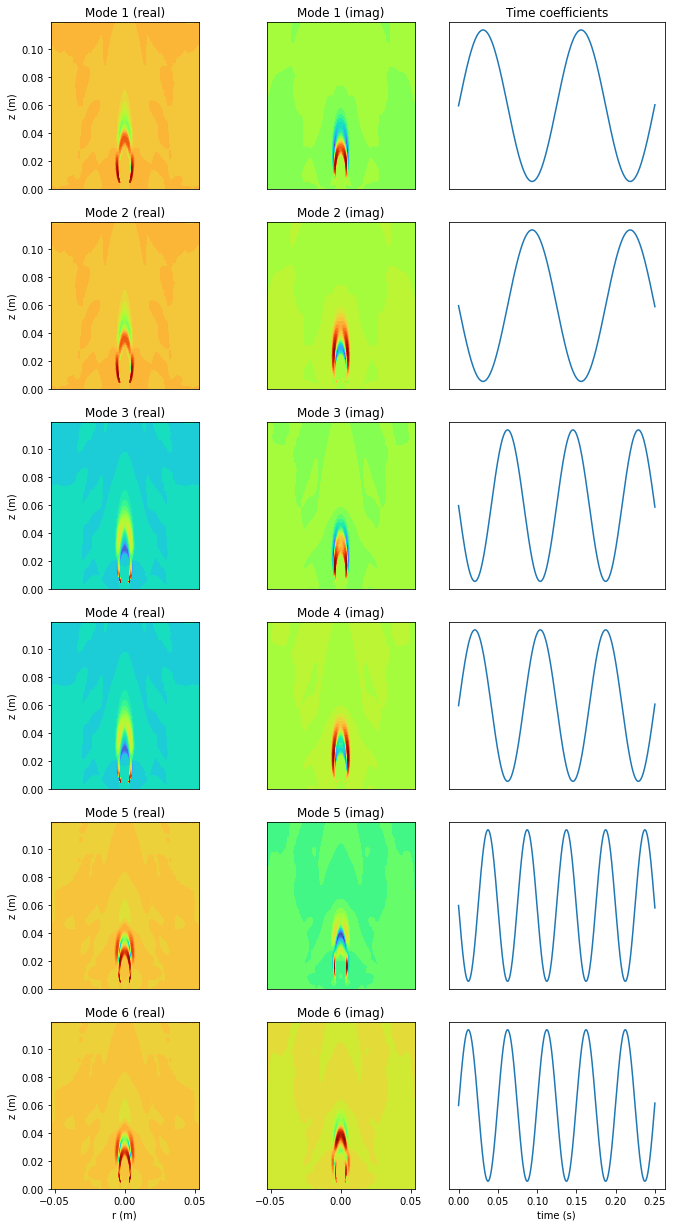

In [4]:
# Plotting utility
def plot_modes_complex(r, z, Phi, Freq, n_modes, filename=''):
    fig, axs = plt.subplots(nrows=n_modes, ncols=3, figsize=(10, n_modes*3))
    levels = 32
    
    timesteps = np.arange(0, 0.25025, step=0.0005)
    r_mirror = np.concatenate((r, -r))
    z_mirror = np.concatenate((z, z))
    
    triang = tri.Triangulation(r_mirror, z_mirror)
    
    for i in range(n_modes):
        mode_real = np.concatenate((np.real(Phi[:,i]), np.real(Phi[:,i])))
        mode_imag = np.concatenate((np.imag(Phi[:,i]), np.imag(Phi[:,i])))
        axs[i,0].tricontourf(triang, mode_real, levels, cmap='turbo')
        axs[i,0].set_aspect('equal')
        axs[i,0].set_ylabel('z (m)')
        axs[i,0].set_ylim(bottom=0)
        axs[i,0].set_title(f'Mode {i+1} (real)')
        
        axs[i,1].tricontourf(triang, mode_imag, levels, cmap='turbo')
        axs[i,1].set_aspect('equal')
        axs[i,1].tick_params(axis='y', which='both', left=False, labelleft=False)
        axs[i,1].set_ylim(bottom=0)
        axs[i,1].set_title(f'Mode {i+1} (imag)')
        
        if i < n_modes - 1:
            axs[i,0].tick_params(axis='x', which='both', bottom=False, labelbottom=False)
            axs[i,1].tick_params(axis='x', which='both', bottom=False, labelbottom=False)
            axs[i,2].tick_params(axis='x', which='both', bottom=False, labelbottom=False)
        else:
            axs[i,0].set_xlabel('r (m)')
            axs[i,2].set_xlabel('time (s)')
        
        time = np.sin(2*np.pi*Freq[i]*timesteps)
        axs[i,2].plot(timesteps, time)
        axs[i,2].tick_params(axis='y', which='both', left=False, labelleft=False)
        if i == 0:
            axs[i,2].set_title('Time coefficients')
                 
    # fig.tight_layout()
    fig.subplots_adjust(bottom=0.05, top=.95, left=0.05, right=.95, wspace=0.0, hspace=0.2)

    if filename != '':
        fig.savefig(filename, transparent=True, dpi=600, bbox_inches='tight')    
    
    plt.show()

n_modes = 6
plot_modes_complex(xyz[:,0], xyz[:,2], Phi, Freq, n_modes)

In [5]:
def exact_DMD(X):
    m = X.shape[1]
    X1 = X[:,:m-1]
    X2 = X[:,1:m]
    
    print('Computing SVD...')
    U, S, Vt = np.linalg.svd(X1, full_matrices=False)
    V = Vt.T
    
    print('Computing A_tilde...')
    A_tilde = U.T @ X2 @ V @ np.diag(1/S)
    
    print('Computing eigenvalues of A_tilde...')
    L, W = np.linalg.eig(A_tilde)
    
    print('Computing DMD modes...')
    Phi = 1/L * X2 @ V @ np.diag(1/S) @ W.T

    print('Done.')    
    return Phi, L
    

Phi, L = exact_DMD(X0_f10)

Omega_r = np.sqrt(L.real**2 + L.imag**2)
Omega_f = np.angle(L)

Computing SVD...
Computing A_tilde...
Computing eigenvalues of A_tilde...
Computing DMD modes...
Done.


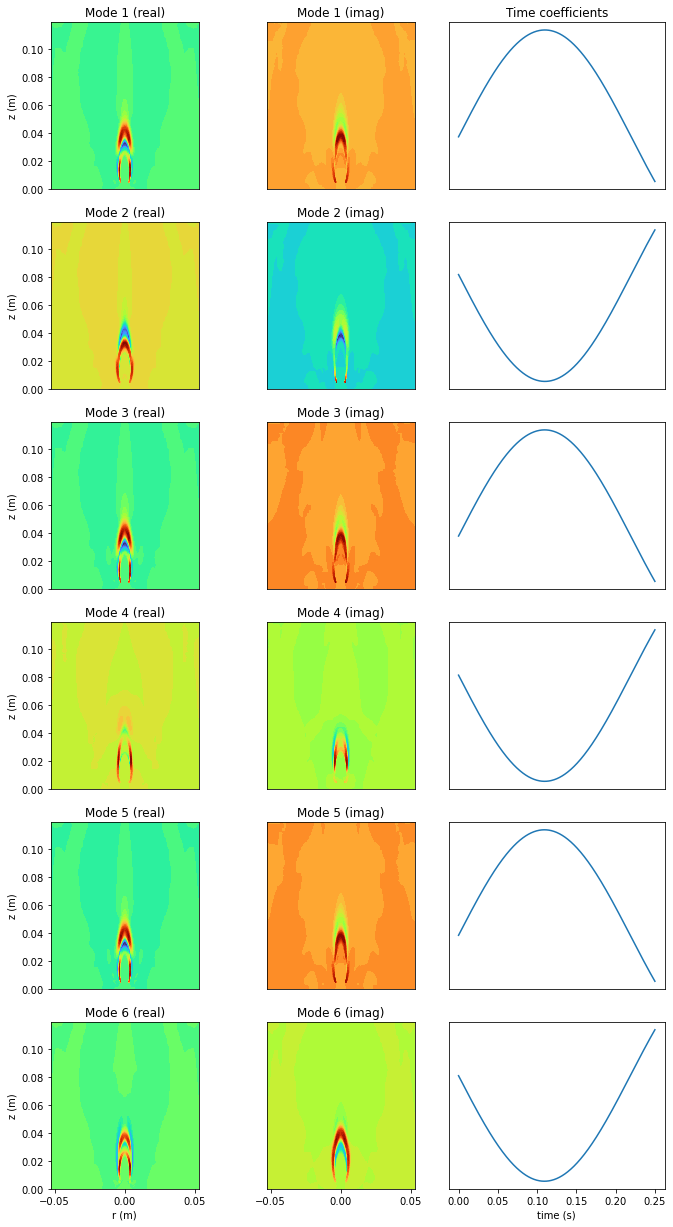

In [6]:
n_modes = 6
plot_modes_complex(xyz[:,0], xyz[:,2], Phi, Omega_f, n_modes)